<a href="https://colab.research.google.com/github/getChan/data_campus/blob/master/NLP/Data_Labeling_(DIY).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Labeling Lab

## Goal
본 실습의 목표는 Amazon Mechanical Turk와 같은 플랫폼을 통해 사용자들로부터 데이터에 정답을 부착했을 때, 이를 머신러닝 학습에 사용할 수 있도록 후처리하는 방법을 배우는 것입니다.

## Dataset

In [0]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

학습 데이터를 다운로드하고 압축을 풉니다.

데이터 출처: http://www.cs.cornell.edu/~cristian/Politeness.html

In [0]:
if not os.path.exists("Stanford_politeness_corpus.zip"):
  !wget http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip

if not os.path.exists("Stanford_politeness_corpus/wikipedia.annotated.csv"):
  !unzip Stanford_politeness_corpus.zip

다운로드된 데이터셋은 CSV 파일 형태로 되어 있습니다.

pandas 패키지의 read_csv 함수를 이용하면 이를 편리하게 읽어올 수 있습니다.

In [39]:
data = pd.read_csv("Stanford_politeness_corpus/wikipedia.annotated.csv")
pd.set_option('display.max_columns', None)

print(data.head())

   Community      Id                                            Request  \
0  Wikipedia  629705  Where did you learn English? How come you're t...   
1  Wikipedia  244336  Thanks very much for your edit to the <url> ar...   
2  Wikipedia  627353  Sir i think u hav many friends on wiki who can...   
3  Wikipedia  448565  I can't find it.  Maybe I didn't manage to gue...   
4  Wikipedia  625810  I can't spend too much time, and I'm no specia...   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      13       9      11      11       5  A2UFD1I8ZO1V4G  A2YFPO0N4GIS25   
1      23      16      24      21      25  A2QN0EGBRGJU1M  A2GSW5RBAT5LQ5   
2      17      17      11      10       9  A233ONYNWKDIYF  A2UFD1I8ZO1V4G   
3      17       9      16      16       9  A233ONYNWKDIYF  A1TLLJDX8H4JP1   
4      17      14      17      11      17  A21753FQKCM5DQ   AYG3MF094634L   

          TurkId3         TurkId4         TurkId5  Normalized Score  
0   AYG3MF094634

각 칼럼에 대한 자세한 정보 등은 Readme.txt 파일에 있습니다.

Community - always "Wikipedia" in this file

Id - Unique ID of the request (can be used to match the requests with the metadata in  wikipedia.requests.csv)

Request - text of the request

Score[1-5] - politeness scores assigned by each of the 5 annotators, between 1 (very impolite) and 25 (very polite)

TurkId[1-5]	- the Amazon Mechanical Turk ids of each of the 5 annotators

Normalized Score - the normalized politeness score of the requests (after normalizing each annotator's score; details in Section 2 of the paper)


가장 단순하게는 5개 Score의 평균을 내서 각 문장에 대한 정답을 부여할 수 있을 것입니다.

이런 방법으로 각 문장마다 점수를 내고 이를 시각화해볼까요?

   Community      Id                                            Request  \
0  Wikipedia  629705  Where did you learn English? How come you're t...   
1  Wikipedia  244336  Thanks very much for your edit to the <url> ar...   
2  Wikipedia  627353  Sir i think u hav many friends on wiki who can...   
3  Wikipedia  448565  I can't find it.  Maybe I didn't manage to gue...   
4  Wikipedia  625810  I can't spend too much time, and I'm no specia...   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      13       9      11      11       5  A2UFD1I8ZO1V4G  A2YFPO0N4GIS25   
1      23      16      24      21      25  A2QN0EGBRGJU1M  A2GSW5RBAT5LQ5   
2      17      17      11      10       9  A233ONYNWKDIYF  A2UFD1I8ZO1V4G   
3      17       9      16      16       9  A233ONYNWKDIYF  A1TLLJDX8H4JP1   
4      17      14      17      11      17  A21753FQKCM5DQ   AYG3MF094634L   

          TurkId3         TurkId4         TurkId5  Normalized Score  avg_score  
0   A

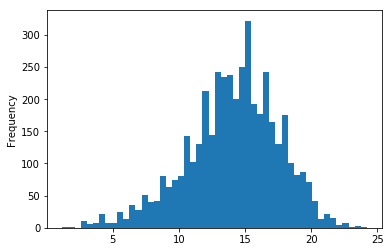

In [40]:
def calc_avg(row):
  sum = 0
  for i in range(1, 6, 1):
    sum += row["Score%d" %i]
  
  return sum / 5.0
  
data["avg_score"] = data.apply(lambda row: calc_avg(row), axis=1)

print(data.head())
data["avg_score"].plot.hist(bins=50)

위 방법에는 몇 가지 문제가 있습니다.


1.   사람마다 느끼는 공손함의 정도는 주관적입니다.
2.   각 문장마다 서로 다른 사람이 점수를 부여했기 때문에 같은 점수를 같은 정도의 공손함이라고 해석할 수 없습니다.

이를 해결하기 위해, 각 사람마다의 점수 분포를 정규화해줄 수 있습니다.

TurkId 항목을 이용해 각각의 사람이 부여한 점수를 모으고, 이로부터 각 사람이 부여한 점수의 평균과 표준편차를 계산해봅시다.



In [0]:
idlist = list(set(data.TurkId1) | set(data.TurkId2) | set(data.TurkId3) | set(data.TurkId4) | set(data.TurkId5))

In [42]:
worker_scores = defaultdict(list)

for idx, row in data.iterrows():
  worker_scores[row.TurkId1].append(row.Score1)
  worker_scores[row.TurkId2].append(row.Score2)
  worker_scores[row.TurkId3].append(row.Score3)
  worker_scores[row.TurkId4].append(row.Score4)
  worker_scores[row.TurkId5].append(row.Score5)

# Your code here

worker_mean = {}
worker_std = {}

for key, value in worker_scores.items():
  worker_mean[key] = np.mean(value)
  worker_std[key] = np.std(value)

# Your code here
  
print(worker_mean)
print(worker_std)
                  

{'A2UFD1I8ZO1V4G': 15.004895104895105, 'A2YFPO0N4GIS25': 14.478632478632479, 'AYG3MF094634L': 14.239160839160839, 'A38WUWONC7EXTO': 13.846153846153847, 'A15DM9BMKZZJQ6': 12.384615384615385, 'A2QN0EGBRGJU1M': 15.086538461538462, 'A2GSW5RBAT5LQ5': 13.076923076923077, 'AO5E3LWBYM72K': 17.13736263736264, 'A2ULMYRKQMNNFG': 15.457013574660634, 'A3TFQK7QK8X6LM': 13.376923076923077, 'A233ONYNWKDIYF': 13.66698982064954, 'A2MWGIVIKOXWYM': 14.817307692307692, 'A1F4D2PZ7NNWTL': 13.599792099792099, 'A1RT9SQ9D9DLOV': 14.085972850678733, 'A1TLLJDX8H4JP1': 10.446153846153846, 'AC25X12LNYY6Y': 13.927350427350428, 'AEYHIQUDWJ3KV': 14.043956043956044, 'A21753FQKCM5DQ': 14.153846153846153, 'A3EJ5TT2ZGBIDA': 13.447115384615385, 'A3G7QIYLFOXFG7': 13.692307692307692, 'AZOAW8JH5HJJK': 12.538461538461538, 'A1Y3Z92RE62NPS': 13.846153846153847, 'A3S5L3I8O3Q2G': 13.20673076923077, 'A26YKYQIA3GX8B': 12.607427055702917, 'AIPK94CUWL45W': 14.34860883797054, 'ARYGQ46IMW8AU': 14.723076923076922, 'A3CFNUD7VR2E1E': 12.80

그 다음으로, 각 사람이 부여한 점수에서 그 사람의 점수들의 평균을 빼고, 표준편차로 나누어줍니다. 

이를 z-normalization이라고 합니다.

이렇게 하면 모든 사람의 점수가 평균 0, 표준편차 1의 분포를 가지게 됩니다. 따라서 점수를 부여한 사람을 신경쓰지 않고 점수들을 비교할 수 있습니다.

In [44]:
# Your code here
def z_norm(row, i):
  return (row['Score%d' %i] - worker_mean[row['TurkId%d' %i]]) / worker_std[row['TurkId%d' %i]]

for i in range(1,6):
  data["Score%d_ZN" %i] = data.apply(lambda row : z_norm(row, i), axis=1)
print(data.head())

   Community      Id                                            Request  \
0  Wikipedia  629705  Where did you learn English? How come you're t...   
1  Wikipedia  244336  Thanks very much for your edit to the <url> ar...   
2  Wikipedia  627353  Sir i think u hav many friends on wiki who can...   
3  Wikipedia  448565  I can't find it.  Maybe I didn't manage to gue...   
4  Wikipedia  625810  I can't spend too much time, and I'm no specia...   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      13       9      11      11       5  A2UFD1I8ZO1V4G  A2YFPO0N4GIS25   
1      23      16      24      21      25  A2QN0EGBRGJU1M  A2GSW5RBAT5LQ5   
2      17      17      11      10       9  A233ONYNWKDIYF  A2UFD1I8ZO1V4G   
3      17       9      16      16       9  A233ONYNWKDIYF  A1TLLJDX8H4JP1   
4      17      14      17      11      17  A21753FQKCM5DQ   AYG3MF094634L   

          TurkId3         TurkId4         TurkId5  Normalized Score  \
0   AYG3MF09463

이제 사람들 간의 점수 편차를 최소화했으니, 정규화된 점수들의 평균을 내봅시다.

평균 점수를 계산하고, 이를 "Normalized Score" 칼럼의 값과 비교해보세요.

이전과 같이 히스토그램을 통해 시각화도 해보시기 바랍니다.

   Community      Id                                            Request  \
0  Wikipedia  629705  Where did you learn English? How come you're t...   
1  Wikipedia  244336  Thanks very much for your edit to the <url> ar...   
2  Wikipedia  627353  Sir i think u hav many friends on wiki who can...   
3  Wikipedia  448565  I can't find it.  Maybe I didn't manage to gue...   
4  Wikipedia  625810  I can't spend too much time, and I'm no specia...   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      13       9      11      11       5  A2UFD1I8ZO1V4G  A2YFPO0N4GIS25   
1      23      16      24      21      25  A2QN0EGBRGJU1M  A2GSW5RBAT5LQ5   
2      17      17      11      10       9  A233ONYNWKDIYF  A2UFD1I8ZO1V4G   
3      17       9      16      16       9  A233ONYNWKDIYF  A1TLLJDX8H4JP1   
4      17      14      17      11      17  A21753FQKCM5DQ   AYG3MF094634L   

          TurkId3         TurkId4         TurkId5  Normalized Score  \
0   AYG3MF09463

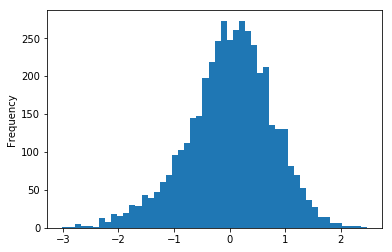

In [45]:
# Your code here

def calc_avg_an(row):
  sum = 0
  for i in range(1,6,1):
    sum += row["Score%d_ZN"%i]
  return sum / 5.0

data["avg_zn_score"] = data.apply(lambda row: calc_avg_an(row), axis=1)

print(data.head())
data["avg_zn_score"].plot.hist(bins=50)

이제 각 문장마다 공손함 점수는 부여했지만, 아직 하나의 문제가 더 남았습니다.

공손함은 모호한 개념이기 때문에, 그리고 공손함을 따지기 어려운 중립적인 문장들이 많기 때문에 지금의 데이터에는 공손함을 따지기 어려운 중립적인 문장들이 많습니다.

이러한 경우는 점수가 중간에 분포하는 문장들을 학습 데이터에서 제거하는 것이 일반적입니다.

이 데이터에서는 가장 공손한 문장 25%와 가장 불손한 문장 25%만을 사용하고, 나머지는 폐기하겠습니다.

In [46]:
def load_data(data_file):
  data = pd.read_csv(data_file)

  # Only use the top quartile as polite, and bottom quartile as impolite. Discard the rest.
  quantiles = data["Normalized Score"].quantile([0.25, 0.5, 0.75])
  print(quantiles)

  # Your code here

  return data

data = load_data("Stanford_politeness_corpus/wikipedia.annotated.csv")
print(data.head())
print("데이터 수: %d" %len(data))

0.25   -0.442633
0.50    0.052339
0.75    0.514399
Name: Normalized Score, dtype: float64
   Community      Id                                            Request  \
0  Wikipedia  629705  Where did you learn English? How come you're t...   
1  Wikipedia  244336  Thanks very much for your edit to the <url> ar...   
2  Wikipedia  627353  Sir i think u hav many friends on wiki who can...   
3  Wikipedia  448565  I can't find it.  Maybe I didn't manage to gue...   
4  Wikipedia  625810  I can't spend too much time, and I'm no specia...   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      13       9      11      11       5  A2UFD1I8ZO1V4G  A2YFPO0N4GIS25   
1      23      16      24      21      25  A2QN0EGBRGJU1M  A2GSW5RBAT5LQ5   
2      17      17      11      10       9  A233ONYNWKDIYF  A2UFD1I8ZO1V4G   
3      17       9      16      16       9  A233ONYNWKDIYF  A1TLLJDX8H4JP1   
4      17      14      17      11      17  A21753FQKCM5DQ   AYG3MF094634L 